# Meteo Forecast data preparation
This notebook aims to handle the meteo features for all Italy zones and produce an input file to give to a Variational Auto Encoder. Each Italy zone will have a unique file with specified characteristics

# 1: Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow # needed for importing dataframes
import warnings
from functools import reduce
import calendar
import os

import pvlib
from pvlib.location import Location
from scipy.interpolate import interp1d
from scipy.integrate import quad

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore') # silence warnings

# 2: Zone selection
Carefully pick one of the ITALY zones

In [2]:
'''
italy_zones = ['IT_CALA','IT_CNOR','IT_CSUD','IT_SARD','IT_SICI','IT_SUD','IT_NORD']
'''
sel_zone = 'IT_CNOR'

# make directory for saving screenshots
directory_name = f'1_plots/{sel_zone}'
try:
    os.mkdir(directory_name)
    print(f"Directory '{directory_name}' created successfully.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{directory_name}'.")
except Exception as e:
    print(f"An error occurred: {e}")

Directory '1_plots/IT_CNOR' already exists.


# 3: Datasets extraction
### 3.1: 2t dataset (temperature)

,node_id,2t,year,month,day,hour,day_of_week,2t_1d,2t_2d
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,IT_CNOR,279.492298,2022,1,1,0,Saturday,0.000000,0.000000
2022-01-01 03:00:00+00:00,IT_CNOR,278.545741,2022,1,1,3,Saturday,-0.946557,0.000000
2022-01-01 06:00:00+00:00,IT_CNOR,278.514555,2022,1,1,6,Saturday,-0.031186,0.915370
2022-01-01 09:00:00+00:00,IT_CNOR,279.698770,2022,1,1,9,Saturday,1.184215,1.215401
2022-01-01 12:00:00+00:00,IT_CNOR,282.558938,2022,1,1,12,Saturday,2.860168,1.675953
...,...,...,...,...,...,...,...,...,...
2025-01-24 21:00:00+00:00,IT_CNOR,280.426503,2025,1,24,21,Friday,-1.584828,0.829104
2025-01-25 00:00:00+00:00,IT_CNOR,279.989324,2025,1,25,0,Saturday,-0.437179,1.147649
2025-01-25 03:00:00+00:00,IT_CNOR,279.455625,2025,1,25,3,Saturday,-0.533699,-0.096520


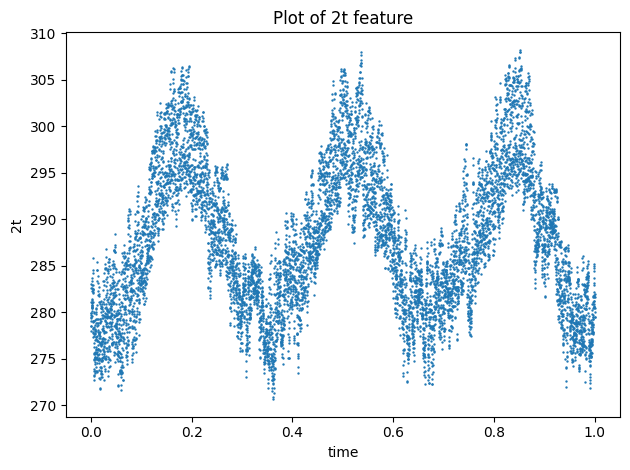

In [3]:
filename = "1_meteo_forecast_data/2t_pop.zst"

df_2t = pd.read_parquet(filename)  # this reads .zst files efficiently

# extracting the time information
df_2t['year'] = pd.to_datetime(df_2t.index).year
df_2t['month'] = pd.to_datetime(df_2t.index).month
df_2t['day'] = pd.to_datetime(df_2t.index).day
df_2t['hour'] = pd.to_datetime(df_2t.index).hour
df_2t['day_of_week'] = pd.to_datetime(df_2t.index).day_name()

# keeping only the right zone
sel_2t = df_2t[df_2t['node_id'] == sel_zone]

# computing the first derivative
sel_2t['2t_1d'] = sel_2t.loc[:,'2t'].diff()
# computing the second derivative
sel_2t['2t_2d'] = sel_2t.loc[:,'2t_1d'].diff()

# set NA values to 0 (.diff() leaves out first values)
sel_2t.loc[sel_2t.index[0], '2t_1d'] = 0
sel_2t.loc[sel_2t.index[0], '2t_2d'] = 0
sel_2t.loc[sel_2t.index[1], '2t_2d'] = 0

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, 1, len(sel_2t['year']))

# plot the data to check if there is a reasonable trend (no clear outliers)
#plt.scatter(time, sel_2t['2t'], s=0.5)
plt.scatter(time, sel_2t['2t'], s=.5)
plt.xlabel('time')
plt.ylabel('2t')
plt.title('Plot of 2t feature')
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/2t_feature.png')
sel_2t


### 3.2: tp dataset (rain)

,node_id,tp,year,month,day,hour,day_of_week
date_time,,,,,,,
2021-12-31 18:00:00+00:00,IT_CNOR,5.843944e-06,2021,12,31,18,Friday
2022-01-01 06:00:00+00:00,IT_CNOR,1.238103e-06,2022,1,1,6,Saturday
2022-01-01 18:00:00+00:00,IT_CNOR,2.700683e-06,2022,1,1,18,Saturday
2022-01-02 06:00:00+00:00,IT_CNOR,6.488192e-06,2022,1,2,6,Sunday
2022-01-02 18:00:00+00:00,IT_CNOR,1.515004e-05,2022,1,2,18,Sunday
...,...,...,...,...,...,...,...
2024-12-29 18:00:00+00:00,IT_CNOR,9.759825e-09,2024,12,29,18,Sunday
2024-12-30 06:00:00+00:00,IT_CNOR,1.115409e-08,2024,12,30,6,Monday
2024-12-30 18:00:00+00:00,IT_CNOR,1.394261e-08,2024,12,30,18,Monday


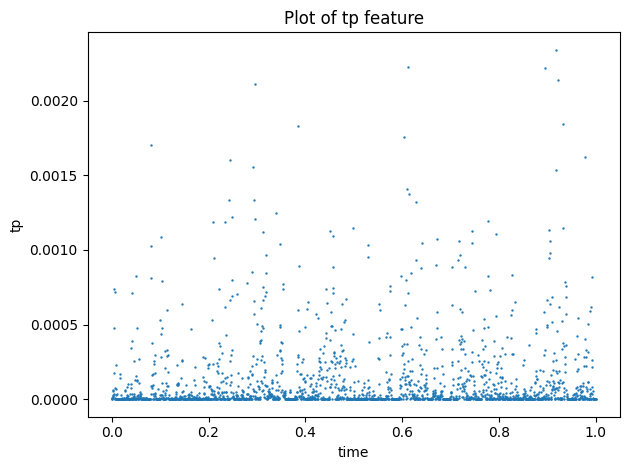

In [4]:
filename = "1_meteo_forecast_data/tp_no_mask.zst"

df_tp = pd.read_parquet(filename) # this reads .zst files efficiently

# extracting the time information
df_tp['year'] = pd.to_datetime(df_tp.index).year
df_tp['month'] = pd.to_datetime(df_tp.index).month
df_tp['day'] = pd.to_datetime(df_tp.index).day
df_tp['hour'] = pd.to_datetime(df_tp.index).hour
df_tp['day_of_week'] = pd.to_datetime(df_tp.index).day_name()

# keeping only the right zone
sel_tp = df_tp[df_tp['node_id'] == sel_zone]

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, 1, len(sel_tp['year']))

# plot the data to check if there is a reasonable trend (no clear outliers)
plt.scatter(time, sel_tp['tp'], s = 0.5)
plt.xlabel('time')
plt.ylabel('tp')
plt.title('Plot of tp feature')
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/tp_feature.png')
sel_tp


### 3.3: ssrd solar dataset

,node_id,ssrd,year,month,day,hour,day_of_week
date_time,,,,,,,
2021-12-31 18:00:00+00:00,IT_CNOR,0.000000e+00,2021,12,31,18,Friday
2022-01-01 06:00:00+00:00,IT_CNOR,5.229823e+05,2022,1,1,6,Saturday
2022-01-01 18:00:00+00:00,IT_CNOR,0.000000e+00,2022,1,1,18,Saturday
2022-01-02 06:00:00+00:00,IT_CNOR,4.636451e+05,2022,1,2,6,Sunday
2022-01-02 18:00:00+00:00,IT_CNOR,0.000000e+00,2022,1,2,18,Sunday
...,...,...,...,...,...,...,...
2025-01-23 06:00:00+00:00,IT_CNOR,4.396634e+05,2025,1,23,6,Thursday
2025-01-23 18:00:00+00:00,IT_CNOR,0.000000e+00,2025,1,23,18,Thursday
2025-01-24 06:00:00+00:00,IT_CNOR,5.415897e+05,2025,1,24,6,Friday


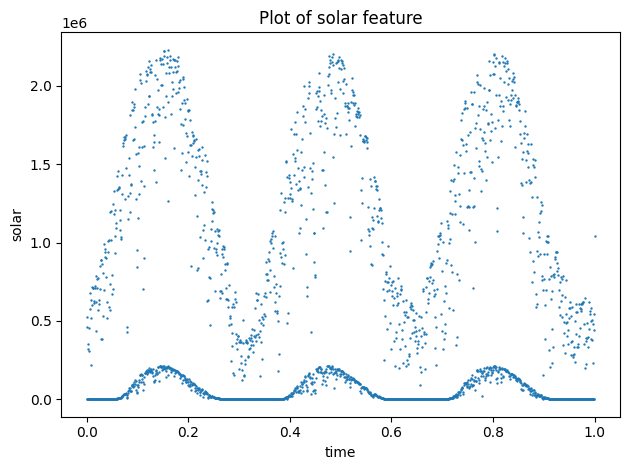

In [5]:
filename = "1_meteo_forecast_data/ssrd_solar.zst"

df_solar = pd.read_parquet(filename) # this reads .zst files efficiently

# extracting the time information
df_solar['year'] = pd.to_datetime(df_solar.index).year
df_solar['month'] = pd.to_datetime(df_solar.index).month
df_solar['day'] = pd.to_datetime(df_solar.index).day
df_solar['hour'] = pd.to_datetime(df_solar.index).hour
df_solar['day_of_week'] = pd.to_datetime(df_solar.index).day_name()

# keeping only the right zone
sel_solar = df_solar[df_solar['node_id'] == sel_zone]

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, 1, len(sel_solar['year']))

# plot the data to check if there is a reasonable trend (no clear outliers)
plt.scatter(time, sel_solar['ssrd'], s = 0.5)
plt.xlabel('time')
plt.ylabel('solar')
plt.title('Plot of solar feature')
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/solar_feature.png')

sel_solar


### 3.4: wind speed (10 meters)

,node_id,ws_10m,year,month,day,hour,day_of_week,ws_10m_1d,ws_10m_2d
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,IT_CNOR,1.651873,2022,1,1,0,Saturday,0.000000,0.000000
2022-01-01 03:00:00+00:00,IT_CNOR,1.501089,2022,1,1,3,Saturday,-0.150784,0.000000
2022-01-01 06:00:00+00:00,IT_CNOR,1.570277,2022,1,1,6,Saturday,0.069188,0.069188
2022-01-01 09:00:00+00:00,IT_CNOR,1.308249,2022,1,1,9,Saturday,-0.262028,-0.262028
2022-01-01 12:00:00+00:00,IT_CNOR,1.599029,2022,1,1,12,Saturday,0.290781,0.290781
...,...,...,...,...,...,...,...,...,...
2025-01-25 03:00:00+00:00,IT_CNOR,1.369713,2025,1,25,3,Saturday,-0.162210,-0.162210
2025-01-25 06:00:00+00:00,IT_CNOR,1.586781,2025,1,25,6,Saturday,0.217068,0.217068
2025-01-25 09:00:00+00:00,IT_CNOR,2.170402,2025,1,25,9,Saturday,0.583620,0.583620


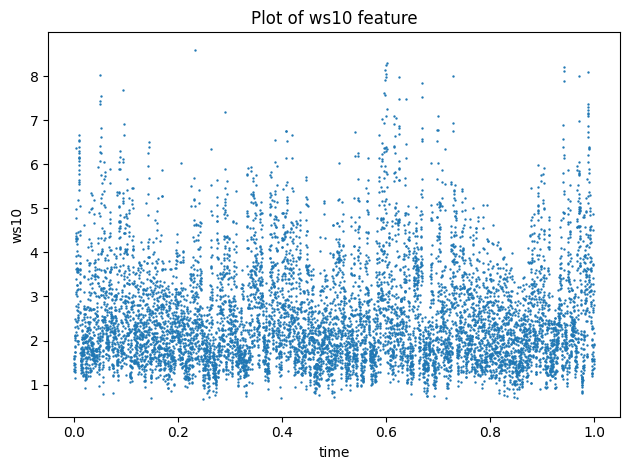

In [6]:
filename = "1_meteo_forecast_data/ws_10m_wind.zst"

df_ws10 = pd.read_parquet(filename) # this reads .zst files efficiently

# extracting the time information
df_ws10['year'] = pd.to_datetime(df_ws10.index).year
df_ws10['month'] = pd.to_datetime(df_ws10.index).month
df_ws10['day'] = pd.to_datetime(df_ws10.index).day
df_ws10['hour'] = pd.to_datetime(df_ws10.index).hour
df_ws10['day_of_week'] = pd.to_datetime(df_ws10.index).day_name()

# keeping only the right zone
sel_ws10 = df_ws10[df_ws10['node_id'] == sel_zone]

# computing the first derivative
sel_ws10['ws_10m_1d'] = sel_ws10.loc[:,'ws_10m'].diff()
# computing the second derivative
sel_ws10['ws_10m_2d'] = sel_ws10.loc[:,'ws_10m'].diff()

# set NA values to 0 (.diff() leaves out first values)
sel_ws10.loc[sel_ws10.index[0], 'ws_10m_1d'] = 0
sel_ws10.loc[sel_ws10.index[0], 'ws_10m_2d'] = 0
sel_ws10.loc[sel_ws10.index[1], 'ws_10m_2d'] = 0

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, 1, len(sel_ws10['year']))

# plot the data to check if there is a reasonable trend (no clear outliers)
plt.scatter(time, sel_ws10['ws_10m'], s = 0.5)
plt.xlabel('time')
plt.ylabel('ws10')
plt.title('Plot of ws10 feature')
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/ws10_feature.png')

sel_ws10


### 3.5: wind speed (100 m)

,node_id,ws_100m,year,month,day,hour,day_of_week,ws_100m_1d,ws_100m_2d
date_time,,,,,,,,,
2022-01-01 00:00:00+00:00,IT_CNOR,2.612491,2022,1,1,0,Saturday,0.000000,0.000000
2022-01-01 03:00:00+00:00,IT_CNOR,2.267224,2022,1,1,3,Saturday,-0.345267,0.000000
2022-01-01 06:00:00+00:00,IT_CNOR,2.194866,2022,1,1,6,Saturday,-0.072359,-0.072359
2022-01-01 09:00:00+00:00,IT_CNOR,1.973030,2022,1,1,9,Saturday,-0.221835,-0.221835
2022-01-01 12:00:00+00:00,IT_CNOR,1.845371,2022,1,1,12,Saturday,-0.127659,-0.127659
...,...,...,...,...,...,...,...,...,...
2025-01-25 18:00:00+00:00,IT_CNOR,4.020256,2025,1,25,18,Saturday,-0.120976,-0.120976
2025-01-25 21:00:00+00:00,IT_CNOR,4.378373,2025,1,25,21,Saturday,0.358117,0.358117
2025-01-26 00:00:00+00:00,IT_CNOR,4.861160,2025,1,26,0,Sunday,0.482786,0.482786


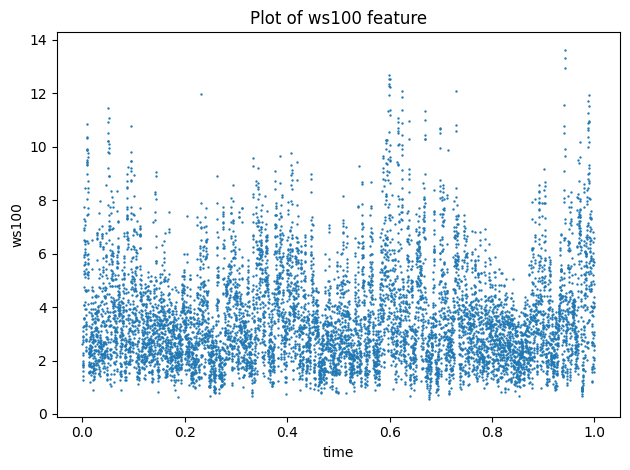

In [7]:
filename = "1_meteo_forecast_data/ws_100m_wind.zst"

df_ws100 = pd.read_parquet(filename) # this reads .zst files efficiently

# extracting the time information
df_ws100['year'] = pd.to_datetime(df_ws100.index).year
df_ws100['month'] = pd.to_datetime(df_ws100.index).month
df_ws100['day'] = pd.to_datetime(df_ws100.index).day
df_ws100['hour'] = pd.to_datetime(df_ws100.index).hour
df_ws100['day_of_week'] = pd.to_datetime(df_ws100.index).day_name()

# keeping only the right zone
sel_ws100 = df_ws100[df_ws100['node_id'] == sel_zone]

# computing the first derivative
sel_ws100['ws_100m_1d'] = sel_ws100.loc[:,'ws_100m'].diff()
# computing the second derivative
sel_ws100['ws_100m_2d'] = sel_ws100.loc[:,'ws_100m'].diff()

# set NA values to 0 (.diff() leaves out first values)
sel_ws100.loc[sel_ws100.index[0], 'ws_100m_1d'] = 0
sel_ws100.loc[sel_ws100.index[0], 'ws_100m_2d'] = 0
sel_ws100.loc[sel_ws100.index[1], 'ws_100m_2d'] = 0

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, 1, len(sel_ws100['year']))

# plot the data to check if there is a reasonable trend (no clear outliers)
plt.scatter(time, sel_ws100['ws_100m'], s = 0.5)
plt.xlabel('time')
plt.ylabel('ws100')
plt.title('Plot of ws100 feature')
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/ws100_feature.png')

sel_ws100


# 4: Reconstructing missing data
Solar and tp dataset have a reduced time acquisition (every 12h) with respect to other features (every 3h). Since our aim is to train the VAE on 3h time windows, we have to infer the correct data points to assign to each timestamp

In [8]:
print('2t:', np.unique(sel_2t['hour']))
print('tp:', np.unique(sel_tp['hour']))
print('solar:', np.unique(sel_solar['hour']))
print('ws10', np.unique(sel_ws10['hour']))
print('ws100', np.unique(sel_ws100['hour']))

2t: [ 0  3  6  9 12 15 18 21]
tp: [ 6 18]
solar: [ 6 18]
ws10 [ 0  3  6  9 12 15 18 21]
ws100 [ 0  3  6  9 12 15 18 21]


### 4.1: Reconstructing solar feature
For solar feature we use a function that estimates the solar irradiation given the azimutal angle (computed with the average of geographical coordinates of the 2 biggest cities in each zone). The total irradiation computed in 3h time windows is set to be equal to the aggregate (every 12h) that we own as original data points.

In [9]:
coordinates = {
    'IT_NORD':[44.962468974,10.354948926], # Average on Milan, Bologna
    'IT_SUD':[40.7981938,17.0548628], # Bari, Taranto
    'IT_CNOR':[43.82613595,11.6104167], # Firenze, Prato
    'IT_CSUD':[41.3644443,13.36569445], # Roma, Napoli
    'IT_CALA':[38.7955556,16.11875], # Reggio Calabria, Catanzaro
    'IT_SICI':[37.8091667,14.59875], # Palermo, Catania
    'IT_SARD':[39.971667,8.8379167] # Cagliari, Sassari
}

In [10]:
# picking the right zone (coordinates and data)
df_sol = df_solar[df_solar['node_id'] == sel_zone]
df_sol.index = pd.to_datetime(df_sol.index)  # Convert index to DatetimeIndex
sel_coor = coordinates[sel_zone]
latitude = sel_coor[0]
longitude = sel_coor[1]

timezone = 'Europe/Rome'
site = Location(latitude, longitude, tz=timezone)

In [11]:
def process_row(row):
    start_utc = row.name
    start = start_utc.tz_convert(timezone)
    E_cum = row['ssrd']
    hour = start.hour
    
    end = start + pd.Timedelta(hours=12)
    times = pd.date_range(start, end, freq='1h', tz=timezone)
    solpos = site.get_solarposition(times) 
    
    theta_z = np.radians(solpos['zenith']) ##zenith angles each of the 12 hours
    cos_theta = np.clip(np.cos(theta_z), 0, None)
    
    integral = np.sum(cos_theta)
    
    base_result = { ### schema for the final dataframe
        'start_time': start,
        'end_time': end,
        'node_id': row['node_id'],
        'original_datetime': start_utc
    }
    
    if integral == 0:
        # night
        results = []
        for t0 in range(6 if hour == 6 else 18, 18 if hour == 6 else 30, 3):
            t1 = t0 + 3
            results.append({
                **base_result,
                'start_time': start + pd.Timedelta(hours=t0-hour),
                'end_time': start + pd.Timedelta(hours=t1-hour),
                'E_3h': 0.0  # Set to zero the 3hours timeframes with no radiations
            })
        return pd.DataFrame(results)
    
    I0 = E_cum / (integral)
    I_t = I0 * cos_theta
    #print(I_t) #I(t) calculated every hour (try printing to check)
    t_decimal = np.array([(t.hour + t.minute/60) + (t.day-start.day)*24 for t in times])
    
    #if len(t_decimal) < 4 or np.all(I_t == 0): ##no need no more
    #    return pd.DataFrame([{**base_result, 'E_3h': 0.0}])
    
    I_func = interp1d(t_decimal, I_t, kind='linear', bounds_error=False, fill_value=0)


    #############
    results = []
    for t0 in range(0, 24, 3):
        t1 = t0 + 3
        if t1 <= t_decimal[0] or t0 >= t_decimal[-1]:
            continue
        try:
            E_i, _ = quad(I_func, t0, t1)
            results.append({
                **base_result,
                'start_time': start.normalize() + pd.Timedelta(hours=t0),
                'end_time': start.normalize() + pd.Timedelta(hours=t1),
                'E_3h': E_i
            })
        except Exception as e:
            print(f"Integration error at {start_utc}: {e}")
            results.append({
                **base_result,
                'start_time': start.normalize() + pd.Timedelta(hours=t0),
                'end_time': start.normalize() + pd.Timedelta(hours=t1),
                'E_3h': 0.0
            }) 
    #################
            
    return pd.DataFrame(results) if results else pd.DataFrame([{**base_result, 'E_3h': 0.0}])
        

def process_dataframe(df_sol):
    all_blocks = []
    
    for idx, row in df_sol.iterrows():
        try:
            result = process_row(row)
            if result is not None:
                all_blocks.append(result)
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
    
    if not all_blocks:
        return pd.DataFrame()
        
    return pd.concat(all_blocks, ignore_index=True)

df_result = process_dataframe(df_sol)
df_result.head(15)


,start_time,end_time,node_id,original_datetime,E_3h
0,2021-12-31 18:00:00+01:00,2021-12-31 21:00:00+01:00,IT_CNOR,2021-12-31 18:00:00+00:00,0.000000
1,2021-12-31 21:00:00+01:00,2022-01-01 00:00:00+01:00,IT_CNOR,2021-12-31 18:00:00+00:00,0.000000
2,2022-01-01 00:00:00+01:00,2022-01-01 03:00:00+01:00,IT_CNOR,2021-12-31 18:00:00+00:00,0.000000
3,2022-01-01 03:00:00+01:00,2022-01-01 06:00:00+01:00,IT_CNOR,2021-12-31 18:00:00+00:00,0.000000
4,2022-01-01 06:00:00+01:00,2022-01-01 09:00:00+01:00,IT_CNOR,2022-01-01 06:00:00+00:00,23056.983660
5,2022-01-01 09:00:00+01:00,2022-01-01 12:00:00+01:00,IT_CNOR,2022-01-01 06:00:00+00:00,211584.800904
6,2022-01-01 12:00:00+01:00,2022-01-01 15:00:00+01:00,IT_CNOR,2022-01-01 06:00:00+00:00,237198.206398
7,2022-01-01 15:00:00+01:00,2022-01-01 18:00:00+01:00,IT_CNOR,2022-01-01 06:00:00+00:00,51142.294752
8,2022-01-01 18:00:00+01:00,2022-01-01 21:00:00+01:00,IT_CNOR,2022-01-01 06:00:00+00:00,0.000000
9,2022-01-01 18:00:00+01:00,2022-01-01 21:00:00+01:00,IT_CNOR,2022-01-01 18:00:00+00:00,0.000000


In [12]:
new_solar = df_result
new_solar = new_solar[['start_time','original_datetime','E_3h']]
new_solar['start_time'] = pd.to_datetime(new_solar['start_time'])  # allow tz-aware

# remove timezone info 
new_solar['start_time'] = new_solar['start_time'].apply(lambda x: x.tz_localize(None) if x.tzinfo is not None else x)

# retrieve time info
new_solar.index = new_solar['start_time']
new_solar['year'] = new_solar.index.year
new_solar['month'] = new_solar.index.month
new_solar['day'] = new_solar.index.day
new_solar['hour'] = new_solar.index.hour
new_solar['day_of_week'] = new_solar.index.day_name()

new_solar[:8]


,start_time,original_datetime,E_3h,year,month,day,hour,day_of_week
start_time,,,,,,,,
2021-12-31 18:00:00,2021-12-31 18:00:00,2021-12-31 18:00:00+00:00,0.000000,2021,12,31,18,Friday
2021-12-31 21:00:00,2021-12-31 21:00:00,2021-12-31 18:00:00+00:00,0.000000,2021,12,31,21,Friday
2022-01-01 00:00:00,2022-01-01 00:00:00,2021-12-31 18:00:00+00:00,0.000000,2022,1,1,0,Saturday
2022-01-01 03:00:00,2022-01-01 03:00:00,2021-12-31 18:00:00+00:00,0.000000,2022,1,1,3,Saturday
2022-01-01 06:00:00,2022-01-01 06:00:00,2022-01-01 06:00:00+00:00,23056.983660,2022,1,1,6,Saturday
2022-01-01 09:00:00,2022-01-01 09:00:00,2022-01-01 06:00:00+00:00,211584.800904,2022,1,1,9,Saturday
2022-01-01 12:00:00,2022-01-01 12:00:00,2022-01-01 06:00:00+00:00,237198.206398,2022,1,1,12,Saturday
2022-01-01 15:00:00,2022-01-01 15:00:00,2022-01-01 06:00:00+00:00,51142.294752,2022,1,1,15,Saturday


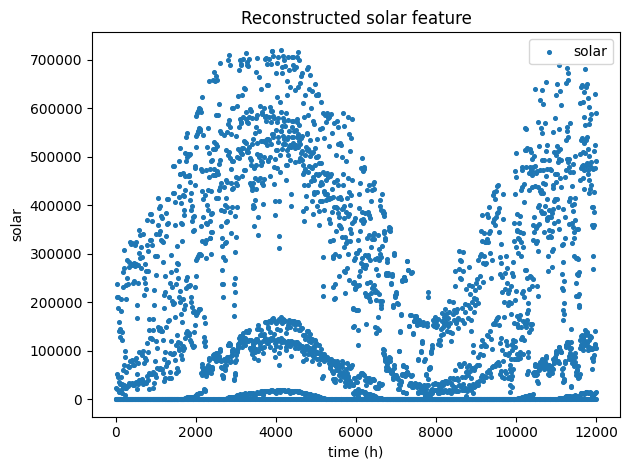

,start_time,original_datetime,year,month,day,hour,day_of_week,solar,solar_1d,solar_2d
start_time,,,,,,,,,,
2021-12-31 18:00:00,2021-12-31 18:00:00,2021-12-31 18:00:00+00:00,2021,12,31,18,Friday,0.000000,0.000000,0.000000
2021-12-31 21:00:00,2021-12-31 21:00:00,2021-12-31 18:00:00+00:00,2021,12,31,21,Friday,0.000000,0.000000,0.000000
2022-01-01 00:00:00,2022-01-01 00:00:00,2021-12-31 18:00:00+00:00,2022,1,1,0,Saturday,0.000000,0.000000,0.000000
2022-01-01 03:00:00,2022-01-01 03:00:00,2021-12-31 18:00:00+00:00,2022,1,1,3,Saturday,0.000000,0.000000,0.000000
2022-01-01 06:00:00,2022-01-01 06:00:00,2022-01-01 06:00:00+00:00,2022,1,1,6,Saturday,23056.983660,23056.983660,23056.983660
...,...,...,...,...,...,...,...,...,...,...
2025-01-25 06:00:00,2025-01-25 06:00:00,2025-01-25 06:00:00+00:00,2025,1,25,6,Saturday,55122.241675,55122.241675,55122.241675
2025-01-25 09:00:00,2025-01-25 09:00:00,2025-01-25 06:00:00+00:00,2025,1,25,9,Saturday,393686.365503,338564.123828,283441.882154
2025-01-25 12:00:00,2025-01-25 12:00:00,2025-01-25 06:00:00+00:00,2025,1,25,12,Saturday,457516.991589,63830.626086,-274733.497742


In [13]:
sel_solar = new_solar
sel_solar['solar'] = sel_solar['E_3h']
sel_solar = sel_solar.drop(columns = 'E_3h')

# computing the first derivative
sel_solar['solar_1d'] = sel_solar.loc[:,'solar'].diff()
# computing the second derivative
sel_solar['solar_2d'] = sel_solar.loc[:,'solar_1d'].diff()

# set NA values to 0 (.diff() leaves out first values)
sel_solar.loc[sel_solar.index[0], 'solar_1d'] = 0
sel_solar.loc[sel_solar.index[0], 'solar_2d'] = 0
sel_solar.loc[sel_solar.index[1], 'solar_2d'] = 0

plot_s = sel_solar['solar'][:4000]

# defining a growing time parameter (for easy plot purposes)
time = np.linspace(0, len(plot_s)*3, len(plot_s))

# plot the data to check if there is a reasonable trend (no clear outliers)
plt.scatter(time, plot_s, s =7, label ='solar')
#plt.scatter(time, sel_solar['solar_1d'], label ='1 derivative', s = 0.5)
plt.xlabel('time (h)')
plt.ylabel('solar')
plt.title('Reconstructed solar feature')
plt.legend()

plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/reconstructed_solar_feature.png')
plt.show()
sel_solar

### 4.2: reconstructing tp feature
Since rainy precipitations do not have an expected schema during the hours of a day, the best model we can implement is a simple division of the real data over the desired timestamps. By doing so we ensure that the aggregate data that we have (every 12h) is equal to the sum of the single timestamps data (every 3h)

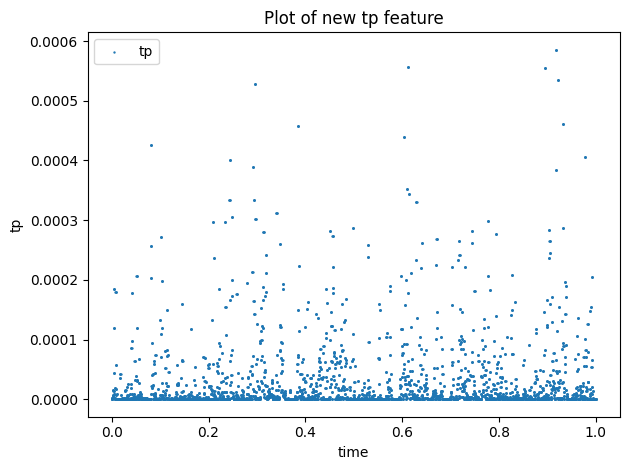

In [14]:
# ensure the df is sorted by datetime
sel_tp.index = pd.to_datetime(sel_tp.index)
sel_tp = sel_tp.sort_index()

# create a new list to hold expanded rows
expanded_rows = []

# iterate over each row in the DataFrame
for timestamp, row in sel_tp.iterrows():
    for i in range(4):
        new_time = timestamp + pd.Timedelta(hours=3 * i)
        original_datetime = timestamp
        new_row = row['tp'] / 4  # divide all values in the row by 4
        expanded_rows.append((new_time,original_datetime, new_row))

# convert to a new DataFrame
new_tp = pd.DataFrame(
    [(r[2],r[1]) for r in expanded_rows],  # this is the tp value (divided by 4)
    index=[r[0] for r in expanded_rows],
    columns=['tp','original_datetime']
)


new_tp.rename(columns={0: 'tp'}, inplace=True)
new_tp['start_time'] = new_tp.index
new_tp['year'] = pd.to_datetime(new_tp.index).year
new_tp['month'] = pd.to_datetime(new_tp.index).month
new_tp['day'] = pd.to_datetime(new_tp.index).day
new_tp['hour'] = pd.to_datetime(new_tp.index).hour
new_tp['day_of_week'] = pd.to_datetime(new_tp.index).day_name()

new_tp = new_tp[['start_time','original_datetime','tp','year','month','day','hour','day_of_week']]
# plot the data to check if there is a reasonable trend (no clear outliers)
time = np.linspace(0, 1, len(new_tp['tp']))

plt.scatter(time, new_tp['tp'], s = 0.5, label ='tp')
#plt.scatter(time, sel_solar['solar_1d'], label ='1 derivative', s = 0.5)
plt.xlabel('time')
plt.ylabel('tp')
plt.title('Plot of new tp feature')
plt.legend()
plt.tight_layout()
plt.savefig(f'1_plots/{sel_zone}/reconstructed_tp_feature.png')
plt.show()


# 5: Merging it all together
We merge all the dataframes that were separated until now. The join is inner, so a record is brought in if all dataframes have a corresponding record. we also remove years that are not 2022, 2023 or 2024.

In [15]:

# returns the number of days in a given month of a given year
def days_in_month(row):
    return calendar.monthrange(row['year'], row['month'])[1]

# merge the dataframes on common indices
all_df = [sel_2t, new_tp, new_solar, sel_ws10, sel_ws100]
df = reduce(lambda left, right: pd.merge(left,right, on = ['year','month','day','hour','day_of_week'], how= 'inner'), all_df)

# let's use the function to correctly assign the total number of days to each record
df['days_in_month'] = df.apply(days_in_month, axis=1)

# recreate date time format
df['timestamp'] = pd.to_datetime({
    'year': df['year'],
    'month': df['month'],
    'day': df['day'],
    'hour': df['hour']
})

# rearrange columns
df = df[['timestamp','year','month','day','hour','2t','solar','tp','ws_10m','ws_100m','days_in_month']]

# keep only 2022, 2023, 2024
years = [2022, 2023, 2024]
df = df[df['year'].isin(years)]

# redefine cyclic time (using sin, cos)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / df['days_in_month'])  # Assume max 31 days
df['day_cos'] = np.cos(2 * np.pi * df['day'] / df['days_in_month'])

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Detect leap year
year = df['year']
day_of_year = df['timestamp'].dt.dayofyear
is_leap_year = ((year % 4 == 0) & ((year % 100 != 0) | (year % 400 == 0)))

# Compute the number of days in the year dynamically
days_in_year = np.where(is_leap_year, 366, 365)

# Now compute angle using correct denominator
angle = 2 * np.pi * (day_of_year / days_in_year)

df['sin_dayofyear'] = np.sin(angle)
df['cos_dayofyear'] = np.cos(angle)

# remove not needed
df = df.drop(columns = ['days_in_month','month','day','hour'])
df


,timestamp,year,2t,solar,tp,ws_10m,ws_100m,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,sin_dayofyear,cos_dayofyear
0,2022-01-01 00:00:00,2022,279.492298,0.000000,1.460986e-06,1.651873,2.612491,0.000000e+00,1.000000e+00,2.012985e-01,0.97953,5.000000e-01,0.866025,1.721336e-02,0.999852
1,2022-01-01 03:00:00,2022,278.545741,0.000000,1.460986e-06,1.501089,2.267224,7.071068e-01,7.071068e-01,2.012985e-01,0.97953,5.000000e-01,0.866025,1.721336e-02,0.999852
2,2022-01-01 06:00:00,2022,278.514555,23056.983660,3.095259e-07,1.570277,2.194866,1.000000e+00,6.123234e-17,2.012985e-01,0.97953,5.000000e-01,0.866025,1.721336e-02,0.999852
3,2022-01-01 09:00:00,2022,279.698770,211584.800904,3.095259e-07,1.308249,1.973030,7.071068e-01,-7.071068e-01,2.012985e-01,0.97953,5.000000e-01,0.866025,1.721336e-02,0.999852
4,2022-01-01 12:00:00,2022,282.558938,237198.206398,3.095259e-07,1.599029,1.845371,1.224647e-16,-1.000000e+00,2.012985e-01,0.97953,5.000000e-01,0.866025,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8253,2024-12-31 12:00:00,2024,283.082279,281328.480098,5.228478e-09,1.051661,1.091363,1.224647e-16,-1.000000e+00,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8254,2024-12-31 15:00:00,2024,282.397011,60215.044732,5.228478e-09,1.161569,1.391009,-7.071068e-01,-7.071068e-01,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8255,2024-12-31 18:00:00,2024,279.458637,0.000000,1.547629e-08,1.132285,1.273759,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8256,2024-12-31 18:00:00,2024,279.458637,0.000000,1.547629e-08,1.132285,1.273759,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.449294e-16,1.000000


# 6: duplicating rows (sliding window approach)
Our aim here is to associate each record to the previous 16, such that each data point is connected to the points within the last 48h. This is done to incentivate correlation seeking in the VAE, linking every point to the 48h before it.

In [16]:
# Separate timestamp and drop from original df
timestamp = df['timestamp']
df = df.drop(columns='timestamp')
steps = 17
columns = df.columns

# Holder lists
expanded_data = []
selected_timestamps = []

# Slide over the DataFrame, looking backward
for i in range(steps - 1, len(df)):
    # Collect the previous 16 rows including current
    window = df.iloc[i - (steps - 1):i + 1].values.flatten()
    expanded_data.append(window)
    selected_timestamps.append(timestamp.iloc[i])  # Timestamp of the current row

# Generate column names for the 16 steps
new_column_names = []
for step in range(steps):
    for col in columns:
        new_column_names.append(f"{col}_t-{steps - 1 - step}")

# Create the expanded DataFrame and add timestamp column
df_expanded = pd.DataFrame(expanded_data, columns=new_column_names)
df_expanded


,year_t-16,2t_t-16,solar_t-16,tp_t-16,ws_10m_t-16,ws_100m_t-16,hour_sin_t-16,hour_cos_t-16,day_sin_t-16,day_cos_t-16,...,ws_10m_t-0,ws_100m_t-0,hour_sin_t-0,hour_cos_t-0,day_sin_t-0,day_cos_t-0,month_sin_t-0,month_cos_t-0,sin_dayofyear_t-0,cos_dayofyear_t-0
0,2022.0,279.492298,0.000000,1.460986e-06,1.651873,2.612491,0.000000e+00,1.000000e+00,0.201299,0.979530,...,1.735816,2.872552,-1.000000e+00,-1.836970e-16,3.943559e-01,0.918958,5.000000e-01,0.866025,3.442161e-02,0.999407
1,2022.0,278.545741,0.000000,1.460986e-06,1.501089,2.267224,7.071068e-01,7.071068e-01,0.201299,0.979530,...,1.842240,2.771695,-7.071068e-01,7.071068e-01,3.943559e-01,0.918958,5.000000e-01,0.866025,3.442161e-02,0.999407
2,2022.0,278.514555,23056.983660,3.095259e-07,1.570277,2.194866,1.000000e+00,6.123234e-17,0.201299,0.979530,...,1.648523,2.922635,0.000000e+00,1.000000e+00,5.712682e-01,0.820763,5.000000e-01,0.866025,5.161967e-02,0.998667
3,2022.0,279.698770,211584.800904,3.095259e-07,1.308249,1.973030,7.071068e-01,-7.071068e-01,0.201299,0.979530,...,1.738624,3.122367,7.071068e-01,7.071068e-01,5.712682e-01,0.820763,5.000000e-01,0.866025,5.161967e-02,0.998667
4,2022.0,282.558938,237198.206398,3.095259e-07,1.599029,1.845371,1.224647e-16,-1.000000e+00,0.201299,0.979530,...,2.000926,3.588390,1.000000e+00,6.123234e-17,5.712682e-01,0.820763,5.000000e-01,0.866025,5.161967e-02,0.998667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,2024.0,279.286998,0.000000,2.439956e-09,1.168674,0.857631,-1.000000e+00,-1.836970e-16,-0.394356,0.918958,...,1.051661,1.091363,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8238,2024.0,279.286998,0.000000,2.439956e-09,1.168674,0.857631,-1.000000e+00,-1.836970e-16,-0.394356,0.918958,...,1.161569,1.391009,-7.071068e-01,-7.071068e-01,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8239,2024.0,278.164837,0.000000,2.439956e-09,0.840955,0.732761,-7.071068e-01,7.071068e-01,-0.394356,0.918958,...,1.132285,1.273759,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000
8240,2024.0,276.709862,0.000000,2.439956e-09,1.089007,0.997343,0.000000e+00,1.000000e+00,-0.201299,0.979530,...,1.132285,1.273759,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000


### 6.1: scaling the features (StandardScaler)

In [17]:
scaler = StandardScaler()

df_scaled = pd.DataFrame(
    scaler.fit_transform(df_expanded), 
    columns=df_expanded.columns, 
    index=df_expanded.index)

df_scaled['timestamp'] = selected_timestamps  # Add timestamp of current row
df_scaled

,year_t-16,2t_t-16,solar_t-16,tp_t-16,ws_10m_t-16,ws_100m_t-16,hour_sin_t-16,hour_cos_t-16,day_sin_t-16,day_cos_t-16,...,ws_100m_t-0,hour_sin_t-0,hour_cos_t-0,day_sin_t-0,day_cos_t-0,month_sin_t-0,month_cos_t-0,sin_dayofyear_t-0,cos_dayofyear_t-0,timestamp
0,-1.224188,-1.050155,-0.787512,-0.431690,-0.798911,-0.563946,0.252071,1.914710,0.281430,1.418152,...,-0.421634,-1.068100,0.260599,0.553856,1.331624,0.703275,1.115037,0.048475,1.294945,2022-01-02 18:00:00
1,-1.224188,-1.166924,-0.787512,-0.431690,-0.929063,-0.750912,1.185852,1.430156,0.281430,1.418152,...,-0.476190,-0.681319,1.430670,0.553856,1.331624,0.703275,1.115037,0.048475,1.294945,2022-01-02 21:00:00
2,-1.224188,-1.170771,-0.670610,-0.450073,-0.869342,-0.790095,1.572637,0.260341,0.281430,1.418152,...,-0.394543,0.252455,1.915329,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 00:00:00
3,-1.224188,-1.024684,0.285252,-0.450073,-1.095517,-0.910222,1.185852,-0.909475,0.281430,1.418152,...,-0.286503,1.186229,1.430670,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 03:00:00
4,-1.224188,-0.671849,0.415116,-0.450073,-0.844524,-0.979351,0.252071,-1.394028,0.281430,1.418152,...,-0.034420,1.573011,0.260599,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,1.225674,-1.075481,-0.787512,-0.454976,-1.215993,-1.514224,-1.068496,0.260341,-0.555722,1.331924,...,-1.385121,0.252455,-1.394132,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 12:00:00
8238,1.225674,-1.075481,-0.787512,-0.454976,-1.215993,-1.514224,-1.068496,0.260341,-0.555722,1.331924,...,-1.223035,-0.681319,-0.909473,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 15:00:00
8239,1.225674,-1.213913,-0.787512,-0.454976,-1.498870,-1.581843,-0.681711,1.430156,-0.555722,1.331924,...,-1.286458,-1.068100,0.260599,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 18:00:00
8240,1.225674,-1.393402,-0.787512,-0.454976,-1.284759,-1.438569,0.252071,1.914710,-0.284393,1.418152,...,-1.286458,-1.068100,0.260599,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 18:00:00


### NOTE: handling the output
Since every 14 ordered columns represent a timestep, removing multiples of 14 removes a full timestep, reducing the number of points gaven in input. For example, for keeping only the previous day (not the day before) the observed timestamp t, you can keep df_scaled[(14*8) : ] where 8 is the number of timestamps of one full day. Remember the extra column to the right contains the timestamp of t

# 7: Final output

In [18]:
df_scaled.to_csv(f"1_output/{sel_zone}_meteo_forecast_data.csv")
df_scaled

,year_t-16,2t_t-16,solar_t-16,tp_t-16,ws_10m_t-16,ws_100m_t-16,hour_sin_t-16,hour_cos_t-16,day_sin_t-16,day_cos_t-16,...,ws_100m_t-0,hour_sin_t-0,hour_cos_t-0,day_sin_t-0,day_cos_t-0,month_sin_t-0,month_cos_t-0,sin_dayofyear_t-0,cos_dayofyear_t-0,timestamp
0,-1.224188,-1.050155,-0.787512,-0.431690,-0.798911,-0.563946,0.252071,1.914710,0.281430,1.418152,...,-0.421634,-1.068100,0.260599,0.553856,1.331624,0.703275,1.115037,0.048475,1.294945,2022-01-02 18:00:00
1,-1.224188,-1.166924,-0.787512,-0.431690,-0.929063,-0.750912,1.185852,1.430156,0.281430,1.418152,...,-0.476190,-0.681319,1.430670,0.553856,1.331624,0.703275,1.115037,0.048475,1.294945,2022-01-02 21:00:00
2,-1.224188,-1.170771,-0.670610,-0.450073,-0.869342,-0.790095,1.572637,0.260341,0.281430,1.418152,...,-0.394543,0.252455,1.915329,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 00:00:00
3,-1.224188,-1.024684,0.285252,-0.450073,-1.095517,-0.910222,1.185852,-0.909475,0.281430,1.418152,...,-0.286503,1.186229,1.430670,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 03:00:00
4,-1.224188,-0.671849,0.415116,-0.450073,-0.844524,-0.979351,0.252071,-1.394028,0.281430,1.418152,...,-0.034420,1.573011,0.260599,0.802529,1.191858,0.703275,1.115037,0.073331,1.293915,2022-01-03 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,1.225674,-1.075481,-0.787512,-0.454976,-1.215993,-1.514224,-1.068496,0.260341,-0.555722,1.331924,...,-1.385121,0.252455,-1.394132,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 12:00:00
8238,1.225674,-1.075481,-0.787512,-0.454976,-1.215993,-1.514224,-1.068496,0.260341,-0.555722,1.331924,...,-1.223035,-0.681319,-0.909473,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 15:00:00
8239,1.225674,-1.213913,-0.787512,-0.454976,-1.498870,-1.581843,-0.681711,1.430156,-0.555722,1.331924,...,-1.286458,-1.068100,0.260599,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 18:00:00
8240,1.225674,-1.393402,-0.787512,-0.454976,-1.284759,-1.438569,0.252071,1.914710,-0.284393,1.418152,...,-1.286458,-1.068100,0.260599,-0.000462,1.446976,-0.018945,1.301485,-0.001275,1.295770,2024-12-31 18:00:00
